# NFT交換アプリによるソーシャルネットワークの分析
## 手法
1. 仮想のソーシャルネットワークの生成
    - NFTを渡す
    - NFTを返す
2. 有向グラフから無向グラフへ変換(オーソリティー信用性)
3. 中心性を求める
4. 中心性からスコア順に並べる

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from random import random

## ①頂点への属性割り当て

### 頂点の用意
- 頂点数：300
- 高信頼者の割合：70%
- データフォーマット
    - trust：1=高信頼者、0=低信頼者
    - group：所属しているグループやコミュニティ(0~3グループ)
    - nft：関心のあるNFTの種類(0~4)

In [2]:
n = 1500
p_trust = 0.5
p_group = 0.25
p_nft = 0.2
color = ["blue", "red", "green", "yellow", "orange"]

In [3]:
trust_list = list()
group_list = list()
nft_list = list()

for i in range(1, n+1):

    # 信頼度の割り当て
    if random() < p_trust:
        trust_list.append(1)
    else:
        trust_list.append(0)

    # グループの割り当て(0~3)
    group = random() / p_group
    group_list.append(int(group))

    # 興味のあるNFTの割り当て(0~4)
    nft = random() / p_nft
    nft_list.append(int(nft))

    # 興味のない


In [4]:
data = [[] for i in range(n)]
for i, (t, g, n) in enumerate(zip(np.array(trust_list), np.array(group_list), np.array(nft_list))):
    data[i] = [t, g, n, 0.0, 0.0, 0.0]

In [5]:
df = pd.DataFrame(data=data, columns=["trust", "group", "nft", "次数中心性", "媒介中心性", "PageRank"])
print(f"頂点数：{len(df)}")
df.head()

頂点数：1500


,trust,group,nft,次数中心性,媒介中心性,PageRank
0,0,3,2,0.0,0.0,0.0
1,1,1,2,0.0,0.0,0.0
2,0,2,2,0.0,0.0,0.0
3,0,0,4,0.0,0.0,0.0
4,1,1,0,0.0,0.0,0.0


## ②グラフの用意
0. グラフの初期化して10%の頂点を追加する
1. 完全グラフを作成して2~3を頂点を繰り返す
2. 頂点を追加する
3. 以下の確率関数$ P(j) $をもとにスケールフリー性を設定する
    - $ n $ ：頂点数
    - $ j $ ：頂点番号
    - $ d_j$：jの次数
$$
    P(j) = \frac{d_j} {\sum_{i=0}^{n}d_n}
$$

In [6]:
# グラフの初期化
n = len(df)
G = nx.DiGraph()
init_number_nodes = int(n * 0.1)
G.add_nodes_from([i for i in range(init_number_nodes)])
ps = [0 for i in range(n)]

# 完全グラフの作成
for i in range(init_number_nodes):
    G.add_edge(i, (i+1)%init_number_nodes)
    G.add_edge(i, (i+2)%init_number_nodes)

# 確率で追加する
for i in range(n):
    G.add_node(i)
    
    for j in range(G.number_of_nodes()):
        if i == j:
            continue

        p = (G.degree(j)) / (G.number_of_edges())
        
        if (p > random()):
            G.add_edge(i, j)
        ps[i] = p


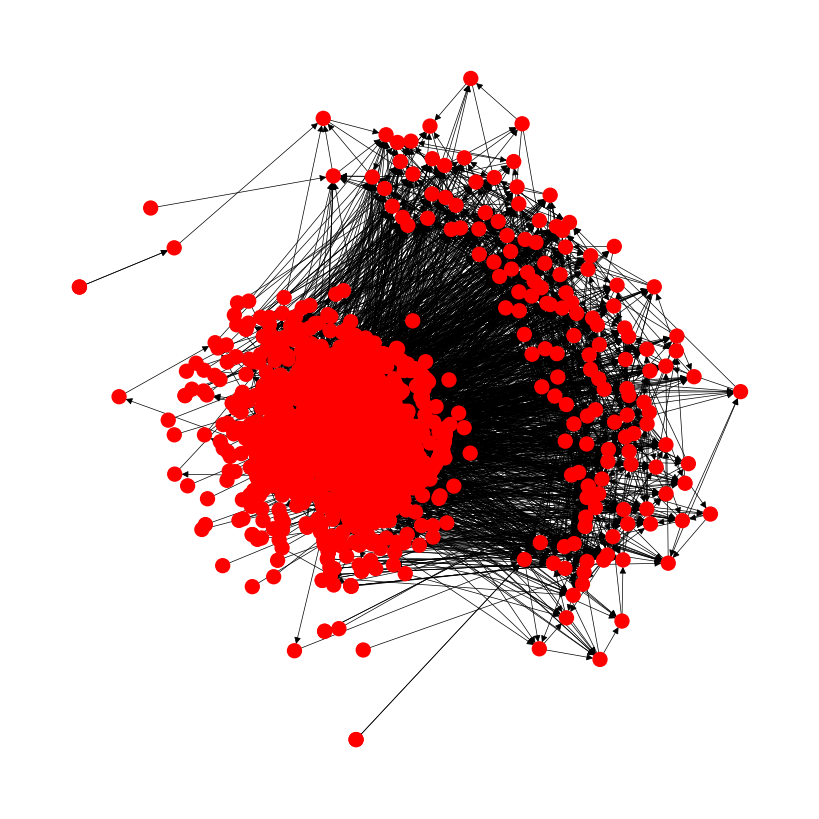

In [7]:
color_map = ["red"] * n
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("data/02preparation_graph.png")
plt.show()

頂点数：1500、辺数：3295
平均次数：2.1966666666666668、最大次数：46


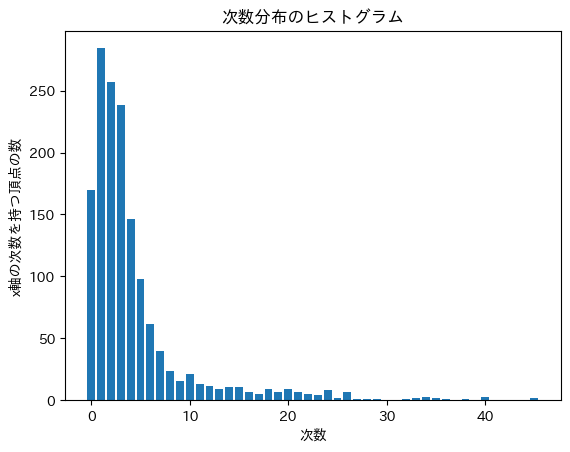

In [8]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.title("次数分布のヒストグラム")
plt.xlabel("次数")
plt.ylabel("x軸の次数を持つ頂点の数")
plt.savefig("data/02degree_histogram.png")
plt.show()

## ③グラフの成長
### (2)交換の応答

#### 類似性による共感や同調
- 次数相関
- 属性の類似性
    - グループ
    - NFTの興味

#### 一般的信頼
- 信用できる人65%、信用できない人35%で応じる
- 場面想定法ではポジティブな情報が一つの場合50%程度から60~~65%の信頼できる人を評価する、逆にネガティブな情報の場合は50%から30~35%の確立で評価するように変化する
<!-- 信頼できる人間同士だと60%、信頼できる or 信頼できない人間だと30%、信頼できない人間同士だと5%の確立で辺をつなぎ返す -->

In [9]:
for edge in G.edges():
    myself = edge[0]
    target = edge[1]
    sim = 0
    p = 0.35

    # 類似性の探索
    for col in ["group", "nft"]:
        if df.loc[myself, col] == df.loc[target, col]:
            sim += 1

    # 高信頼者 or 低信頼者の判定
    if (sim == 2):
        if (df["trust"][target] == 1):
            p = 0.70
        else:
            p = 0.65
    elif (sim == 1):
        if (df["trust"][target] == 1):
            p = 0.65
        else:
            p = 0.60
        
    if random() < p:
        G.add_edge(target, myself)


### NFTを返した後の結果の表示

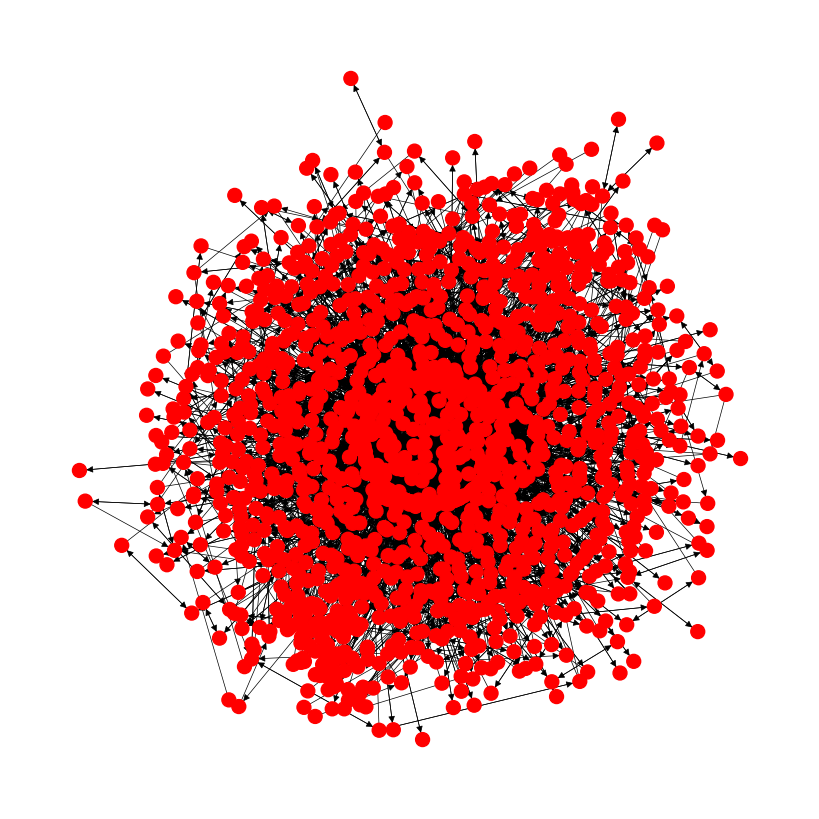

In [10]:
# グラフの表示と保存
color_map = ["red"] * n
plt.figure(figsize=(8, 8))   
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("data/03after_graph.png")
plt.show()

頂点数：1500、辺数：4811
平均次数：3.207333333333333、最大次数：70


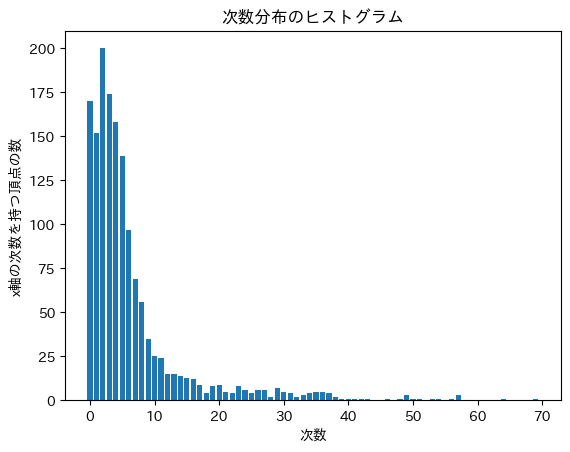

In [11]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.title("次数分布のヒストグラム")
plt.xlabel("次数")
plt.ylabel("x軸の次数を持つ頂点の数")
plt.savefig("data/03degree_histogram.png")
plt.show()

# ソーシャルグラフからスコアを求める

## 有向グラフから無向グラフへ変換
- オーソリティ中心性を求める

In [12]:
# 隣接行列の作成
A = nx.adjacency_matrix(G).todense()
AT = A.transpose()

In [13]:
# 共引用
GC = nx.DiGraph()
GC.add_nodes_from([i for i in range(n)])
M = np.dot(AT, A)
M = M - np.diag(np.diag(M))
for i, row in enumerate(M):
    for j, n in enumerate(row):
        if(n > 0):
            GC.add_edge(i, j)

In [14]:
print("無向グラフの頂点数：", GC.number_of_nodes())
print("無向グラフの辺数：", GC.number_of_edges())

無向グラフの頂点数： 1500
無向グラフの辺数： 26186


## 中心性からスコアを求める
|アルゴリズム名|信用の項目|詳細|
|-------------|-----------|---|
|次元中心性|個別的信用|どれだけ多くの人から信用を受けているのか(ローカル)|
|近傍中心性|×|辺の重みは関係性が低いため|
|媒介中心性|△|経由量は関係性が低いため|
|固有ベクトル中心性|×|多重グラフは利用できないため|
|Katz中心性|×|多重グラフは利用できないため|
|PageRank|個別的信頼|どれだけ多くの人から信用を受けているのか(グローバル)|

In [19]:
def print_centrality(v):
    for key in v:
        print("{:3}：{:<7}".format(key, round(v[key], 5)), end=(" " if (key+1)%5 else "\n"))
    print("")
    print("MAX：", np.argmax(list(v.values())))

def calc_score(v, name):
    temp = np.zeros(len(v))
    for key in v:
        temp[key] = v[key]
    df[name] = temp

### 次数中心性

In [20]:
v = nx.in_degree_centrality(G)
print_centrality(v)
calc_score(v, "次数中心性")

  0：0.00534   1：0.01001   2：0.01134   3：0.01134   4：0.00667
  5：0.00534   6：0.00801   7：0.01601   8：0.01268   9：0.00467
 10：0.01201  11：0.00534  12：0.00867  13：0.00667  14：0.00934
 15：0.02201  16：0.01868  17：0.01401  18：0.01534  19：0.01067
 20：0.00867  21：0.01334  22：0.00334  23：0.02468  24：0.02201
 25：0.006    26：0.01268  27：0.00534  28：0.01134  29：0.01334
 30：0.02201  31：0.01534  32：0.00734  33：0.02735  34：0.01067
 35：0.00801  36：0.01401  37：0.00734  38：0.00734  39：0.00267
 40：0.00801  41：0.00867  42：0.01334  43：0.01334  44：0.006  
 45：0.00934  46：0.01601  47：0.00934  48：0.006    49：0.01868
 50：0.006    51：0.02135  52：0.01067  53：0.01001  54：0.00801
 55：0.01134  56：0.01401  57：0.00667  58：0.01734  59：0.01601
 60：0.01334  61：0.006    62：0.00867  63：0.01067  64：0.00934
 65：0.00334  66：0.00801  67：0.01134  68：0.01001  69：0.01201
 70：0.00734  71：0.01201  72：0.00934  73：0.01001  74：0.006  
 75：0.01268  76：0.02001  77：0.00334  78：0.006    79：0.00734
 80：0.01334  81：0.004    82：0.006    83：

### 媒介中心性

In [21]:
v = nx.betweenness_centrality(G)
print_centrality(v)
calc_score(v, "媒介中心性")

  0：0.00368   1：0.0064    2：0.00703   3：0.01049   4：0.00284
  5：0.00423   6：0.00421   7：0.01448   8：0.01068   9：0.00185
 10：0.00864  11：0.00186  12：0.00664  13：0.00336  14：0.01038
 15：0.02532  16：0.0256   17：0.01131  18：0.01056  19：0.00814
 20：0.00499  21：0.01471  22：0.00139  23：0.0361   24：0.01743
 25：0.00656  26：0.00744  27：0.0023   28：0.01183  29：0.00898
 30：0.02447  31：0.01838  32：0.00585  33：0.03909  34：0.01061
 35：0.0062   36：0.01383  37：0.00567  38：0.00446  39：0.0007 
 40：0.00535  41：0.00642  42：0.01152  43：0.01433  44：0.00491
 45：0.0082   46：0.01139  47：0.00898  48：0.00402  49：0.02207
 50：0.00197  51：0.02333  52：0.00828  53：0.00967  54：0.00483
 55：0.01105  56：0.01413  57：0.00317  58：0.01781  59：0.01479
 60：0.01817  61：0.00298  62：0.00755  63：0.00536  64：0.0033 
 65：0.00245  66：0.00397  67：0.01175  68：0.00617  69：0.01062
 70：0.00378  71：0.01225  72：0.00874  73：0.01025  74：0.00404
 75：0.01083  76：0.02113  77：0.00321  78：0.00185  79：0.0015 
 80：0.01169  81：0.00082  82：0.00445  83：

### PageRank

In [22]:
v = nx.pagerank(G, max_iter=1000)
print_centrality(v)
calc_score(v, "PageRank")

  0：0.00229   1：0.003     2：0.00351   3：0.00318   4：0.00203
  5：0.00177   6：0.00273   7：0.0046    8：0.00409   9：0.00215
 10：0.00373  11：0.00238  12：0.00266  13：0.00214  14：0.00317
 15：0.00623  16：0.00487  17：0.00353  18：0.00407  19：0.00395
 20：0.00282  21：0.00408  22：0.00125  23：0.00604  24：0.00565
 25：0.00192  26：0.00337  27：0.00171  28：0.00246  29：0.00399
 30：0.00616  31：0.00432  32：0.00213  33：0.00708  34：0.00302
 35：0.00211  36：0.00333  37：0.00198  38：0.00161  39：0.00086
 40：0.00207  41：0.00206  42：0.00383  43：0.00361  44：0.00156
 45：0.00265  46：0.00378  47：0.00302  48：0.00185  49：0.00515
 50：0.00147  51：0.00641  52：0.00298  53：0.00266  54：0.00213
 55：0.0029   56：0.00353  57：0.00167  58：0.00519  59：0.00458
 60：0.00382  61：0.00201  62：0.00268  63：0.00276  64：0.00305
 65：0.00135  66：0.00219  67：0.00341  68：0.00293  69：0.00311
 70：0.0023   71：0.0038   72：0.00307  73：0.00317  74：0.00193
 75：0.0036   76：0.00585  77：0.00104  78：0.00193  79：0.00284
 80：0.00517  81：0.00192  82：0.00226  83：

## 最終結果
- 度数分布
- 箱ひげ図
- 次数分布
- 各属性を色分けしたグラフ
    - 高信頼者 or 低信頼者
    - グループ
    - 共通の関心があるか

### 標準偏差

In [23]:
n = len(df)
print("平均値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].mean(numeric_only=True))
print("-" * 50)

print("標準偏差")
print(df[["次数中心性", "媒介中心性", "PageRank"]].std(numeric_only=True))
print("-" * 50)

print("最大値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].max(numeric_only=True))
print("-" * 50)

print("最小値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].min(numeric_only=True))

平均値
次数中心性       0.002140
媒介中心性       0.001483
PageRank    0.000667
dtype: float64
--------------------------------------------------
標準偏差
次数中心性       0.003602
媒介中心性       0.003853
PageRank    0.000980
dtype: float64
--------------------------------------------------
最大値
次数中心性       0.030020
媒介中心性       0.039089
PageRank    0.007264
dtype: float64
--------------------------------------------------
最小値
次数中心性       0.000000
媒介中心性       0.000000
PageRank    0.000111
dtype: float64


### 度数分布

In [24]:
bins = np.arange(0.00, 0.07, 0.01)
ex_l = [[] for i in range(len(bins)-1)]
ex = {
    "次数中心性": [[] for i in range(len(bins)-1)],
    "媒介中心性": [[] for i in range(len(bins)-1)],
    "PageRank": [[] for i in range(len(bins)-1)]
}

for i, data in enumerate(df.values.tolist()):
    for j in range(len(bins)-1):
        if (bins[j] < df.loc[i, "次数中心性"]) and (df.loc[i, "次数中心性"] < bins[j+1]):
            if len(ex["次数中心性"][j]) > 4:
                continue
            ex["次数中心性"][j].append(i)
        if (bins[j] < df.loc[i, "媒介中心性"]) and (df.loc[i, "媒介中心性"] < bins[j+1]):
            if len(ex["媒介中心性"][j]) > 4:
                continue
            ex["媒介中心性"][j].append(i)
        if (bins[j] < df.loc[i, "PageRank"]) and (df.loc[i, "PageRank"] < bins[j+1]):
            if len(ex["PageRank"][j]) > 4:
                continue
            ex["PageRank"][j].append(i)

for score in ["次数中心性", "媒介中心性", "PageRank"]:
    freq = df[score].value_counts(bins=bins, sort=False)
    rel_freq = freq / df[score].count()
    cum_freq = freq.cumsum()
    
    freq_df = pd.DataFrame(
        {
            "度数": freq,
            "相対度数": rel_freq,
            "累積度数": cum_freq,
            "例": ex[score]
        },
        index=freq.index
    )

    print(score)
    print(freq_df)
    print("-"*50)

次数中心性
                  度数      相対度数  累積度数                     例
(-0.001, 0.01]  1419  0.946000  1419       [0, 4, 5, 6, 9]
(0.01, 0.02]      67  0.044667  1486       [1, 2, 3, 7, 8]
(0.02, 0.03]      13  0.008667  1499  [15, 23, 24, 30, 33]
(0.03, 0.04]       1  0.000667  1500                 [109]
(0.04, 0.05]       0  0.000000  1500                    []
(0.05, 0.06]       0  0.000000  1500                    []
(0.06, 0.07]       0  0.000000  1500                    []
--------------------------------------------------
媒介中心性
                  度数      相対度数  累積度数                   例
(-0.001, 0.01]  1434  0.956000  1434     [0, 1, 2, 4, 5]
(0.01, 0.02]      51  0.034000  1485   [3, 7, 8, 14, 24]
(0.02, 0.03]      11  0.007333  1496    [15, 16, 30, 49]
(0.03, 0.04]       4  0.002667  1500  [23, 33, 109, 114]
(0.04, 0.05]       0  0.000000  1500                  []
(0.05, 0.06]       0  0.000000  1500                  []
(0.06, 0.07]       0  0.000000  1500                  []
---------

### 箱ひげ図
- すべて
- 次元中心性
- 媒介中心性
- PageRank

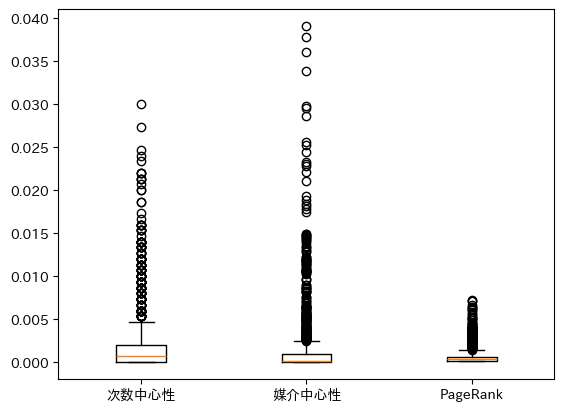

In [26]:
# 各中心性の箱ひげ図
# df[["次数中心性", "媒介中心性", "PageRank"]].boxplot(patch_artist = True, labels=["Degree", "Between", "PageRank"])
plt.boxplot(df[["次数中心性", "媒介中心性", "PageRank"]], labels=["次数中心性", "媒介中心性", "PageRank"])
# plt.title("各スコアの箱ひげ図")
# plt.set_xticklabels(['一様分布', '正規分布'])
# plt.xticks(["Degree", "Between", "PageRank"])
plt.savefig("data/result/box_diagram.png")
plt.show()

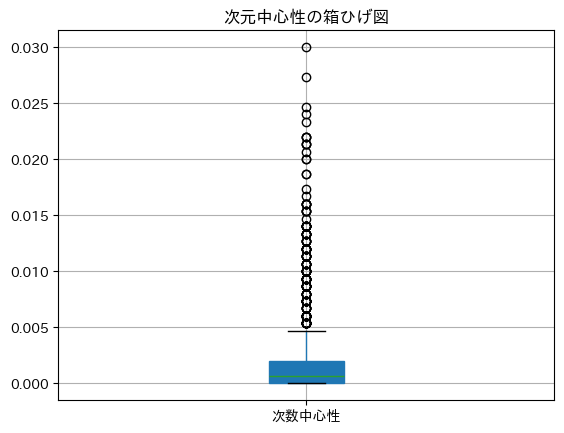

In [27]:
# 次元中心性の箱ひげ図
df[["次数中心性"]].boxplot(patch_artist = True)
plt.title("次元中心性の箱ひげ図")
plt.savefig("data/result/dc_box_diagram.png")
plt.show()

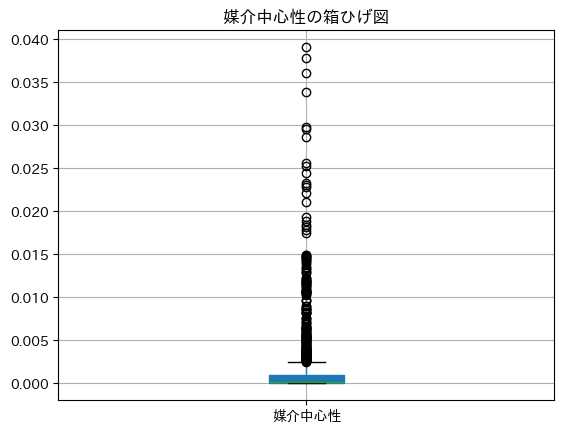

In [28]:
# 媒介中心性の箱ひげ図
df[["媒介中心性"]].boxplot(patch_artist = True)
plt.title("媒介中心性の箱ひげ図")
plt.savefig("data/result/bc_box_diagram.png")
plt.show()

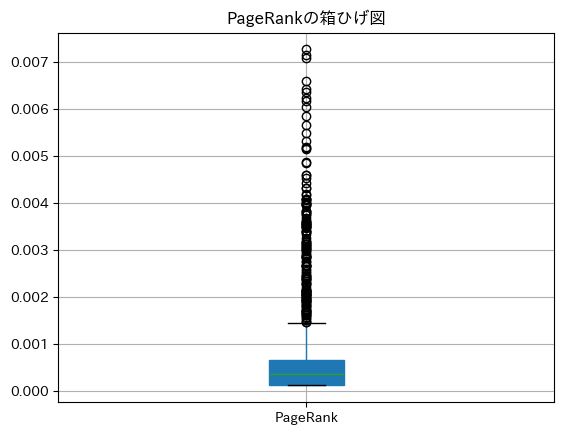

In [29]:
# PageRankの箱ひげ図
df[["PageRank"]].boxplot(patch_artist = True)
plt.title("PageRankの箱ひげ図")
plt.savefig("data/result/pr_box_diagram.png")
plt.show()

### 次数分布

In [30]:
df.to_csv("data/data.csv")
print("# 次元中心性")
print(df.sort_values("次数中心性").head())
print("# 媒介中心性")
print(df.sort_values("媒介中心性").head())
print("# PageRank")
print(df.sort_values("PageRank").head())

# 次元中心性
      trust  group  nft  次数中心性  媒介中心性  PageRank
1185      0      2    0    0.0    0.0  0.000111
1179      0      1    4    0.0    0.0  0.000111
560       0      2    4    0.0    0.0  0.000111
566       0      3    0    0.0    0.0  0.000111
567       1      2    1    0.0    0.0  0.000111
# 媒介中心性
      trust  group  nft  次数中心性  媒介中心性  PageRank
654       0      1    1    0.0    0.0  0.000111
1061      0      0    0    0.0    0.0  0.000111
661       1      2    1    0.0    0.0  0.000111
788       1      3    2    0.0    0.0  0.000111
1336      0      2    3    0.0    0.0  0.000111
# PageRank
      trust  group  nft  次数中心性  媒介中心性  PageRank
574       0      3    3    0.0    0.0  0.000111
573       1      3    3    0.0    0.0  0.000111
1150      1      0    2    0.0    0.0  0.000111
580       0      1    0    0.0    0.0  0.000111
581       1      2    1    0.0    0.0  0.000111


頂点数：1500、辺数：4811
平均次数：3.207333333333333、最大次数：70


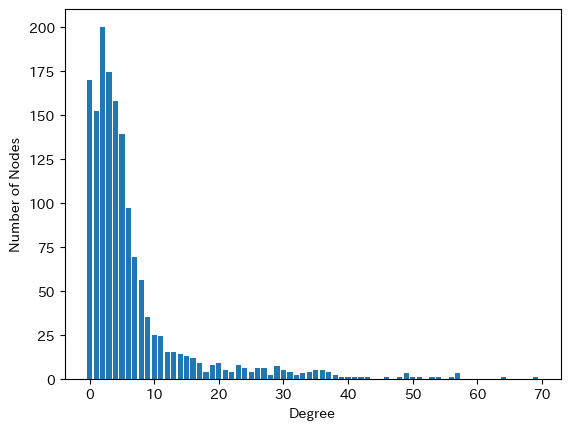

In [31]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.savefig("data/result/degree_histogram.png")
plt.show()

### グラフ
- 高信頼者 or 低信頼者
- グループ
- 共通の関心があるか

In [32]:
pos = nx.kamada_kawai_layout(G)

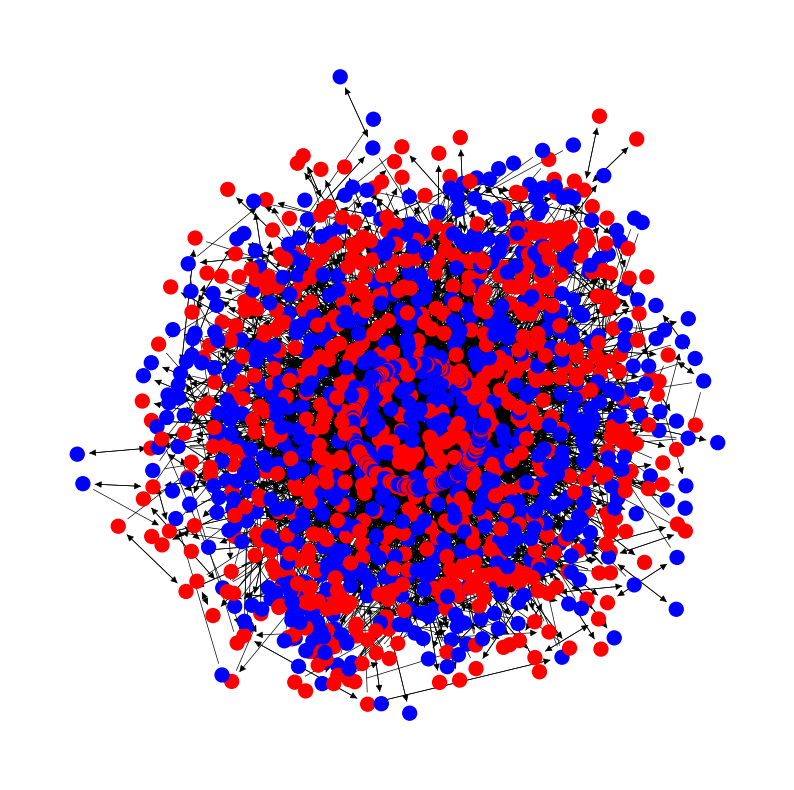

In [33]:
# 高信頼者 or 低信頼者
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["trust"]):
    color_map[i] = color[d]

# グラフの表示と保存
# nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/trust_graph.png")
plt.show()

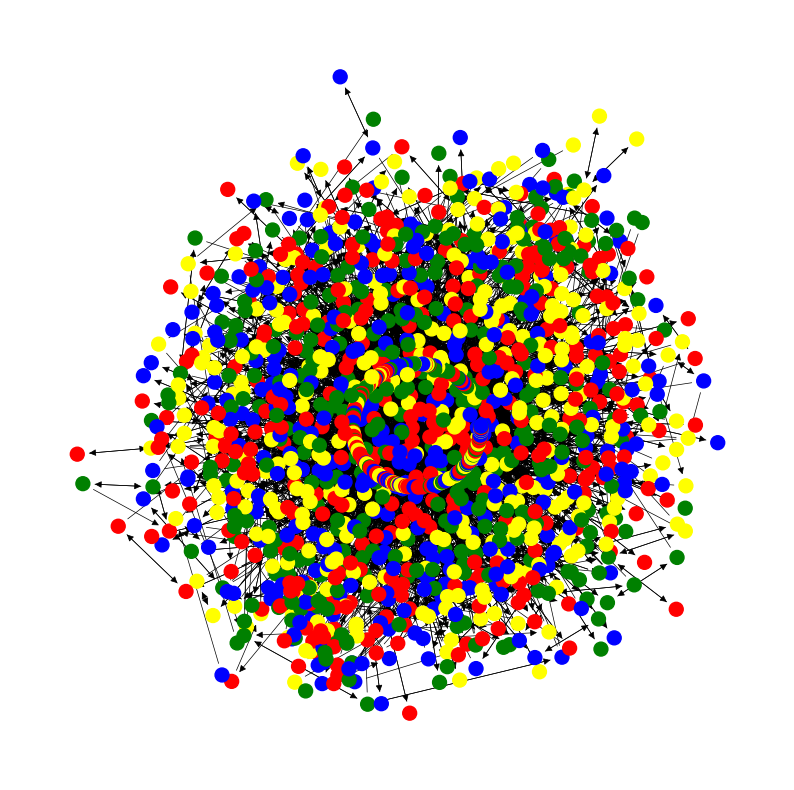

In [34]:
# グループ
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["group"]):
    color_map[i] = color[d]

# グラフの表示と保存
plt.figure(figsize=(10, 10))   
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/group_graph.png")
plt.show()

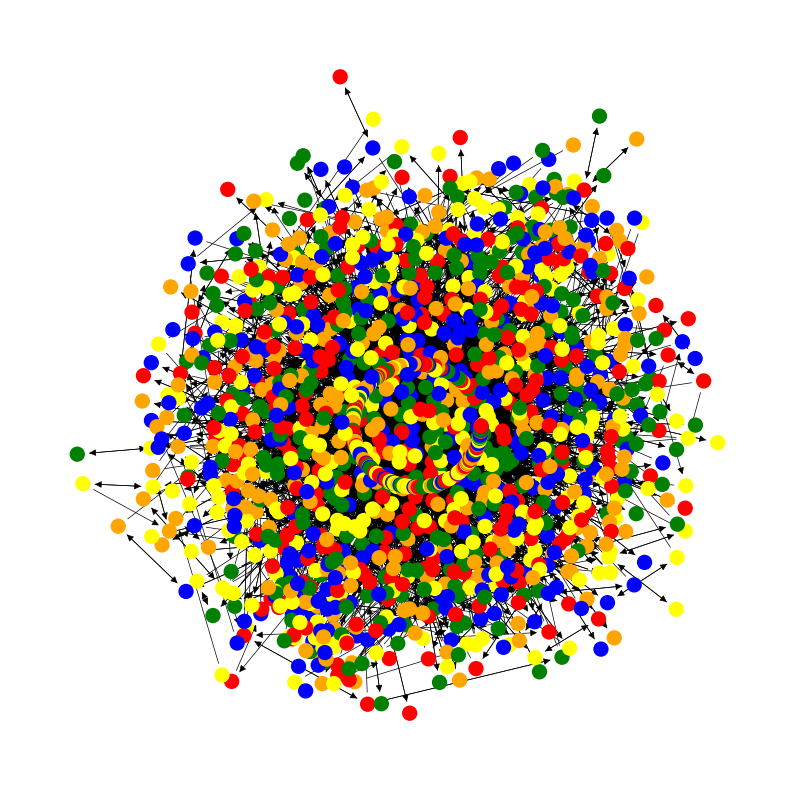

In [35]:
# 共通の関心があるか
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["nft"]):
    color_map[i] = color[d]

# グラフの表示と保存
plt.figure(figsize=(10, 10)) 
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/nft_graph.png")
plt.show()

## グループの抽出

In [36]:
color = ["red", "orange", "yellow", "green", "blue", "purple", "gray"]
lst_m = greedy_modularity_communities(G)
color_map_m = ["black"] * G.number_of_nodes()
for counter, c in enumerate(lst_m):
    for n in c:
        try:
            color_map_m[n] = color[counter]
        except:
            color_map_m[n] = color_map_m[n]

NameError: name 'greedy_modularity_communities' is not defined

In [ ]:
plt.figure(figsize=(10, 10)) 
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map_m)
plt.axis("off")
plt.savefig("data/result/extraction_graph.png")
plt.show()

In [ ]:
df[["次数中心性", "媒介中心性", "PageRank"]].to_csv("data/score.csv")